In [24]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn import tree, preprocessing
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [25]:
connect = sqlite3.connect('FPA_FOD_20170508.sqlite')

# Have wildfires become more or less frequent over time?

<AxesSubplot:xlabel='FIRE_YEAR'>

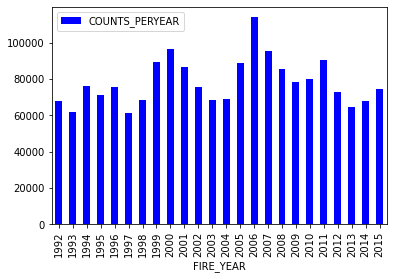

In [6]:
df1 = pd.read_sql_query("SELECT COUNT(OBJECTID) AS COUNTS_PERYEAR, FIRE_YEAR FROM Fires GROUP BY FIRE_YEAR;", connect)
df1.set_index("FIRE_YEAR").plot(kind="bar",color='blue')

<AxesSubplot:xlabel='FIRE_YEAR'>

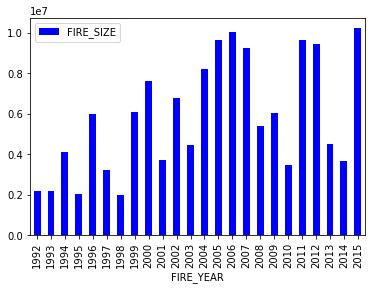

In [63]:
df1 = pd.read_sql_query("SELECT SUM(FIRE_SIZE) AS FIRE_SIZE, FIRE_YEAR FROM Fires GROUP BY FIRE_YEAR;", connect)
df1.set_index("FIRE_YEAR").plot(kind="bar", color='blue')

In [ ]:
# The wildfire count per year is at random while peaking at the year 2006. The size of the wildfire does not shows constant rise but there is more frequent every year.

In [13]:
df = pd.read_sql_query("SELECT FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE FROM 'Fires'", connect)
df.head()

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE
0,2005,Miscellaneous,40.036944,-121.005833,CA,2453403.5,0.10
1,2004,Lightning,38.933056,-120.404444,CA,2453137.5,0.25
2,2004,Debris Burning,38.984167,-120.735556,CA,2453156.5,0.10
3,2004,Lightning,38.559167,-119.913333,CA,2453184.5,0.10
4,2004,Lightning,38.559167,-119.933056,CA,2453184.5,0.10


In [14]:
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df.head()

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,DATE
0,2005,Miscellaneous,40.036944,-121.005833,CA,2453403.5,0.10,2005-02-02
1,2004,Lightning,38.933056,-120.404444,CA,2453137.5,0.25,2004-05-12
2,2004,Debris Burning,38.984167,-120.735556,CA,2453156.5,0.10,2004-05-31
3,2004,Lightning,38.559167,-119.913333,CA,2453184.5,0.10,2004-06-28
4,2004,Lightning,38.559167,-119.933056,CA,2453184.5,0.10,2004-06-28


In [15]:
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
df['DATE'] = pd.to_datetime(df['DATE'])
df['DAY_OF_WEEK'] = df['DATE'].dt.day_name()
df_cause = df.copy()
df.head()

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,DATE,MONTH,DAY_OF_WEEK
0,2005,Miscellaneous,40.036944,-121.005833,CA,2453403.5,0.10,2005-02-02,2,Wednesday
1,2004,Lightning,38.933056,-120.404444,CA,2453137.5,0.25,2004-05-12,5,Wednesday
2,2004,Debris Burning,38.984167,-120.735556,CA,2453156.5,0.10,2004-05-31,5,Monday
3,2004,Lightning,38.559167,-119.913333,CA,2453184.5,0.10,2004-06-28,6,Monday
4,2004,Lightning,38.559167,-119.933056,CA,2453184.5,0.10,2004-06-28,6,Monday


# Most and Least fire Prone

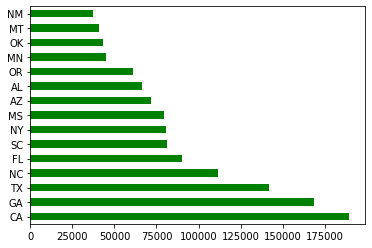

In [69]:
df['STATE'].value_counts().head(n=15).plot(kind='barh',color='green')
plt.show()

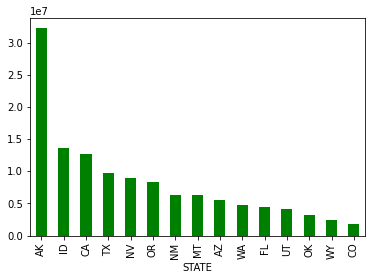

In [70]:
df2 = pd.read_sql_query("SELECT SUM(FIRE_SIZE) AS SUM_FIRE_SIZE, State FROM Fires GROUP BY State;", connect)
df2 = df2.set_index("STATE")
df2["SUM_FIRE_SIZE"].sort_values(ascending=False)[:15].plot(kind="bar",color='green');

In [ ]:
# When it comes to the fire counts the most fire prone state is Carlifornia and least is New Mexico
# When it comes to fire size the most is Alaska and least is Colorado.

# Predict the fire cause

In [21]:
def preprocess(x):
    preprocess = preprocessing.LabelEncoder()
    x = preprocess.fit_transform(x)
    return x
    

In [22]:
df['STAT_CAUSE_DESCR'] = preprocess(df['STAT_CAUSE_DESCR'])
df['STATE'] = preprocess(df['STATE'])
df['DAY_OF_WEEK'] = preprocess(df['DAY_OF_WEEK'])
df.head()


,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,DATE,MONTH,DAY_OF_WEEK
0,2005,7,40.036944,-121.005833,4,2453403.5,0.10,2005-02-02,2,6
1,2004,6,38.933056,-120.404444,4,2453137.5,0.25,2004-05-12,5,6
2,2004,3,38.984167,-120.735556,4,2453156.5,0.10,2004-05-31,5,1
3,2004,6,38.559167,-119.913333,4,2453184.5,0.10,2004-06-28,6,1
4,2004,6,38.559167,-119.933056,4,2453184.5,0.10,2004-06-28,6,1


In [23]:
df = df.drop('DATE',axis=1)
df = df.dropna()

In [24]:
df.head()

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,MONTH,DAY_OF_WEEK
0,2005,7,40.036944,-121.005833,4,2453403.5,0.10,2,6
1,2004,6,38.933056,-120.404444,4,2453137.5,0.25,5,6
2,2004,3,38.984167,-120.735556,4,2453156.5,0.10,5,1
3,2004,6,38.559167,-119.913333,4,2453184.5,0.10,6,1
4,2004,6,38.559167,-119.933056,4,2453184.5,0.10,6,1


In [ ]:
# Feature data - LOCATION, STATE, FIRE_SIZE, DATE
# Label(To predict) - Cause of Fire(STAT_CAUSE_DESCR)

In [ ]:
#Combining different causes into four categories
#0 -> Natural
#1 -> Accidental
#2 -> Malicious
#3 -> Other

In [25]:
def label(x):
    cause = 0
    natural = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if x in natural:
        return 0
    elif x in accidental:
        return 1
    elif x in malicious:
        return 2
    else:
        return 3

df['LABEL'] = df_cause['STAT_CAUSE_DESCR'].apply(lambda x: label(x))
df = df.drop('STAT_CAUSE_DESCR',axis=1)

In [26]:
df.head()

,FIRE_YEAR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,MONTH,DAY_OF_WEEK,LABEL
0,2005,40.036944,-121.005833,4,2453403.5,0.10,2,6,3
1,2004,38.933056,-120.404444,4,2453137.5,0.25,5,6,0
2,2004,38.984167,-120.735556,4,2453156.5,0.10,5,1,1
3,2004,38.559167,-119.913333,4,2453184.5,0.10,6,1,0
4,2004,38.559167,-119.933056,4,2453184.5,0.10,6,1,0


In [29]:
X = df.drop(['LABEL','FIRE_YEAR','STATE'], axis=1).values
y = df['LABEL'].values
y_hat = to_categorical(y, 4)
X_train, X_test, y_train, y_test = train_test_split(X,y_hat,test_size=0.3, random_state=0)


In [16]:
random_forest = ske.RandomForestClassifier(n_estimators=50)
random_forest = random_forest.fit(X_train, y_train)
print(random_forest.score(X_test,y_test))

0.6098379834792782


In [21]:
# Saving the model in pickel format
#pickle.dump(random_forest,open('randomforest_model.pkl','wb'))

In [22]:
# Loading the model
#model = pickle.load(open('randomforest_model.pkl','rb'))

In [54]:
# After downloading the trained model(zip file)from GitHub unzip it and give the path name of the model

model = pickle.load(open('C:\\Users\\sanja\\app\\fire_prediction\\rf_model\\randomforest_model.pkl','rb'))


# INFERENCE

In [23]:
df.drop(['LABEL', 'FIRE_YEAR', 'STATE'], axis=1)

,LATITUDE,LONGITUDE,DISCOVERY_DATE,FIRE_SIZE,MONTH,DAY_OF_WEEK
0,40.036944,-121.005833,2453403.5,0.10,2,6
1,38.933056,-120.404444,2453137.5,0.25,5,6
2,38.984167,-120.735556,2453156.5,0.10,5,1
3,38.559167,-119.913333,2453184.5,0.10,6,1
4,38.559167,-119.933056,2453184.5,0.10,6,1
...,...,...,...,...,...,...
1880460,40.481637,-122.389375,2457291.5,0.01,9,2
1880461,37.617619,-120.938570,2457300.5,0.20,10,1
1880462,37.617619,-120.938570,2457144.5,0.10,5,2
1880463,37.672235,-120.898356,2457309.5,2.00,10,6


In [35]:
causes = {}
incidents = ['Natural', 'Accidental', 'Malicious', 'Other']

for i,cause in enumerate(incidents):
    causes[i] = cause
    

In [53]:
## Manually entering the feature data to predict the cause of the fire

Latitude = float(input('Input Latititude: '))
Longitude = float(input('Input Longitude: '))
Fire_Size = float(input('Fire Size: '))
discovery_date = float(input('Discovery date: '))
Month = float(input('Input Month: '))
Day_Of_Week = float(input('Input Day of Week: '))


Input Latititude: 40.036
Input Longitude: 121.005
Fire Size: 0.10
Discovery date: 2453403.5
Input Month: 2
Input Day of Week: 6


In [ ]:
# REFERENCE

# 0->natural = ['Lightning']
# 1->accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
# 2->malicious = ['Arson']
# 3->other = ['Missing/Undefined','Miscellaneous']

In [55]:
def predict(test):
    probability = []
    
    temp = model.predict_proba(test.reshape((1, 6)))
    for i in range(len(temp)):
        probability.append(temp[i][0][1])
        print(causes[i],':', temp[i][0][1])
    maximum=max(probability)
    index = probability.index(maximum)
    print('Fire Caused by :',causes[index])
    plt.bar(causes.values(), probability)
    

Natural : 0.0
Accidental : 0.24
Malicious : 0.5
Other : 0.26
Fire Caused by : Malicious


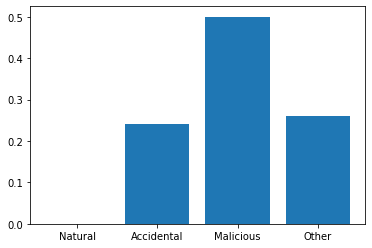

In [56]:
features=[Latitude, Longitude, Fire_Size, discovery_date, Month, Day_Of_Week]
test = np.array(features)
prediction = predict(test)


              precision    recall  f1-score   support

           0       0.42      0.90      0.57     83316
           1       0.72      0.70      0.71    249328
           2       0.70      0.36      0.47     84170
           3       0.79      0.53      0.63    147326

    accuracy                           0.63    564140
   macro avg       0.66      0.62      0.60    564140
weighted avg       0.69      0.63      0.63    564140



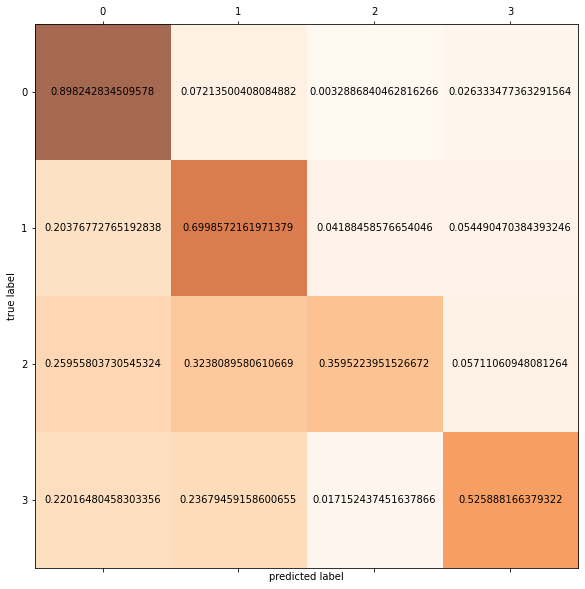

In [124]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = random_forest.predict(X_test)

cm = confusion_matrix(y_true=y_test.argmax(axis=1),y_pred=y_pred.argmax(axis=1))
cr = classification_report(y_true=y_test.argmax(axis=1),y_pred=y_pred.argmax(axis=1))

print(cr)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig,ax = plt.subplots(figsize=(10,10))
ax.matshow(cmn,cmap=plt.cm.Oranges,alpha=0.7)

for i in range(cmn.shape[0]):
    for j in range(cmn.shape[1]):
        ax.text(x=j,y=i,s=cmn[i,j],va='center',ha='center')
        
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [ ]:
# The cause of the fire was predicted using Random Forest Classifier which gave the score of 61%.
# From Confusion matrix we can see that level of prediction is low for class 2(malicious = ['Arson']) and 3(other = ['Missing/Undefined','Miscellaneous']) 

# Here I have used bagging method Random Forest Classifier and wouldnot explore more on Boosting method given the processing power of my CPU.